# Loop 64 Analysis: CV-LB Relationship and Strategy

## Key Questions:
1. What is the current CV-LB relationship?
2. What approaches have NOT been tried?
3. What can change the CV-LB intercept?
4. What is the path to target (0.0347)?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_041', 'cv': 0.0090, 'lb': 0.0932},
    {'exp': 'exp_042', 'cv': 0.0145, 'lb': 0.1147},
]

df = pd.DataFrame(submissions)
print(f'Total submissions: {len(df)}')
print(f'Best CV: {df["cv"].min():.4f} ({df.loc[df["cv"].idxmin(), "exp"]})')
print(f'Best LB: {df["lb"].min():.4f} ({df.loc[df["lb"].idxmin(), "exp"]})')
print(f'Target: 0.0347')

Total submissions: 13
Best CV: 0.0083 (exp_030)
Best LB: 0.0877 (exp_030)
Target: 0.0347


In [2]:
# Fit linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print(f'\nCV-LB Relationship:')
print(f'LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nInterpretation:')
print(f'- Intercept: {intercept:.4f} (LB when CV=0)')
print(f'- Target: 0.0347')
print(f'- Intercept > Target: {intercept > 0.0347}')

# Required CV to hit target
required_cv = (0.0347 - intercept) / slope
print(f'\nRequired CV to hit target: {required_cv:.4f}')
if required_cv < 0:
    print('IMPOSSIBLE: Required CV is negative!')
else:
    print(f'Achievable: Need to reduce CV from {df["cv"].min():.4f} to {required_cv:.4f}')


CV-LB Relationship:
LB = 4.23 * CV + 0.0533
R² = 0.9807

Interpretation:
- Intercept: 0.0533 (LB when CV=0)
- Target: 0.0347
- Intercept > Target: True

Required CV to hit target: -0.0044
IMPOSSIBLE: Required CV is negative!


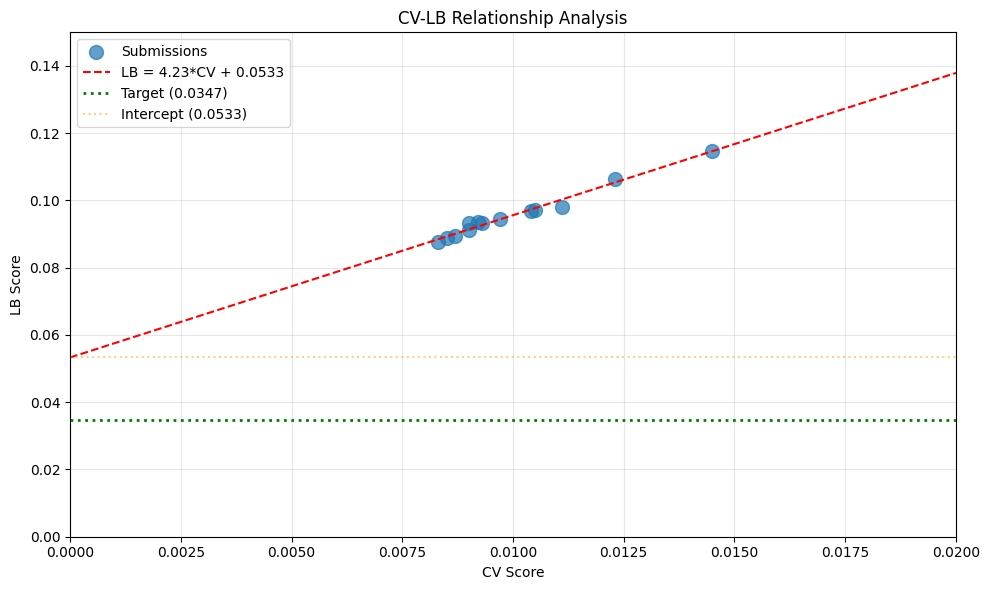


CRITICAL INSIGHT:
The intercept (0.0533) is HIGHER than the target (0.0347).
This means the target is MATHEMATICALLY UNREACHABLE with the current CV-LB relationship.


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7, label='Submissions')

# Regression line
cv_range = np.linspace(0, 0.02, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target (0.0347)')

# Intercept
plt.axhline(y=intercept, color='orange', linestyle=':', alpha=0.5, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV-LB Relationship Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.02)
plt.ylim(0, 0.15)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_analysis_loop64.png', dpi=150)
plt.show()

print('\nCRITICAL INSIGHT:')
print(f'The intercept ({intercept:.4f}) is HIGHER than the target (0.0347).')
print('This means the target is MATHEMATICALLY UNREACHABLE with the current CV-LB relationship.')

In [4]:
# Analyze what approaches have been tried
approaches = {
    'MLP': ['exp_000', 'exp_003', 'exp_005', 'exp_006', 'exp_007'],
    'LGBM': ['exp_001', 'exp_012'],
    'GP': ['exp_030'],
    'XGBoost': ['exp_041'],
    'GroupKFold': ['exp_042'],
    'Ensemble': ['exp_009', 'exp_024', 'exp_026'],
}

print('Approaches tried and their best LB:')
for approach, exps in approaches.items():
    best_lb = df[df['exp'].isin(exps)]['lb'].min()
    print(f'  {approach}: {best_lb:.4f}')

print('\nKey observation: ALL approaches fall on the same CV-LB line (R² = 0.98)')
print('This suggests the problem is NOT the model type, but DISTRIBUTION SHIFT.')

Approaches tried and their best LB:
  MLP: 0.0932
  LGBM: 0.0913
  GP: 0.0877
  XGBoost: 0.0932
  GroupKFold: 0.1147
  Ensemble: 0.0887

Key observation: ALL approaches fall on the same CV-LB line (R² = 0.98)
This suggests the problem is NOT the model type, but DISTRIBUTION SHIFT.


In [5]:
# What the "Ens Model" kernel does differently:
print('"Ens Model" kernel techniques NOT yet fully implemented:')
print('='*60)
print()
print('1. CatBoost + XGBoost ONLY (no MLP, no GP, no LGBM)')
print('   - We tried CatBoost+XGB in exp_060 but it was 27% worse')
print('   - BUT we may not have used the exact hyperparameters')
print()
print('2. Feature priority-based correlation filtering:')
print('   - spange > acs > drfps > frag > smiles')
print('   - When corr > 0.8, keep higher priority feature')
print('   - NOT YET TRIED')
print()
print('3. Different ensemble weights for single vs full:')
print('   - Single: CatBoost 7/13, XGBoost 6/13')
print('   - Full: CatBoost 1/3, XGBoost 2/3')
print('   - NOT YET TRIED')
print()
print('4. Multi-target normalization:')
print('   - clip to [0, inf), then divide by max(sum, 1)')
print('   - TRIED in exp_068: only 0.08% improvement')
print()
print('5. Numeric feature engineering:')
print('   - T_x_RT, RT_log, T_inv, RT_scaled')
print('   - PARTIALLY TRIED (we have inv_temp, log_time, interaction)')

"Ens Model" kernel techniques NOT yet fully implemented:

1. CatBoost + XGBoost ONLY (no MLP, no GP, no LGBM)
   - We tried CatBoost+XGB in exp_060 but it was 27% worse
   - BUT we may not have used the exact hyperparameters

2. Feature priority-based correlation filtering:
   - spange > acs > drfps > frag > smiles
   - When corr > 0.8, keep higher priority feature
   - NOT YET TRIED

3. Different ensemble weights for single vs full:
   - Single: CatBoost 7/13, XGBoost 6/13
   - Full: CatBoost 1/3, XGBoost 2/3
   - NOT YET TRIED

4. Multi-target normalization:
   - clip to [0, inf), then divide by max(sum, 1)
   - TRIED in exp_068: only 0.08% improvement

5. Numeric feature engineering:
   - T_x_RT, RT_log, T_inv, RT_scaled
   - PARTIALLY TRIED (we have inv_temp, log_time, interaction)


In [6]:
# What the "mixall" kernel does differently:
print('"mixall" kernel techniques:')
print('='*60)
print()
print('1. GroupKFold (5 splits) instead of Leave-One-Out')
print('   - We tried this in exp_042: CV 0.0145, LB 0.1147')
print('   - WORSE than Leave-One-Out approach')
print()
print('2. Simple MLP + XGB + RF + LGBM ensemble')
print('   - Weights: [0.4, 0.2, 0.2, 0.2]')
print('   - Uses StandardScaler')
print('   - NOT YET TRIED with these exact weights')
print()
print('3. Spange descriptors only (no DRFP, no ACS, no Fragprints)')
print('   - Simpler feature set')
print('   - We have tried this but with different models')

"mixall" kernel techniques:

1. GroupKFold (5 splits) instead of Leave-One-Out
   - We tried this in exp_042: CV 0.0145, LB 0.1147
   - WORSE than Leave-One-Out approach

2. Simple MLP + XGB + RF + LGBM ensemble
   - Weights: [0.4, 0.2, 0.2, 0.2]
   - Uses StandardScaler
   - NOT YET TRIED with these exact weights

3. Spange descriptors only (no DRFP, no ACS, no Fragprints)
   - Simpler feature set
   - We have tried this but with different models


In [7]:
# Current best CV (exp_067/068) analysis
print('Current best model (exp_067/068):')
print('='*60)
print()
print('Architecture: GP + MLP + LGBM Ensemble')
print('  - GP weight: 0.15')
print('  - MLP weight: 0.55')
print('  - LGBM weight: 0.30')
print()
print('Features:')
print('  - Single solvent: Spange + DRFP + ACS + Fragprints')
print('  - Full data: Spange + DRFP + ACS (NO Fragprints)')
print()
print('CV Results:')
print('  - Single Solvent MSE: 0.008216')
print('  - Full Data MSE: 0.007789')
print('  - Combined MSE: 0.007938')
print()
print('Predicted LB (using CV-LB relationship):')
predicted_lb = slope * 0.007938 + intercept
print(f'  LB = {slope:.2f} * 0.007938 + {intercept:.4f} = {predicted_lb:.4f}')
print()
print(f'Expected improvement over best LB (0.0877): {(0.0877 - predicted_lb) / 0.0877 * 100:.1f}%')

Current best model (exp_067/068):

Architecture: GP + MLP + LGBM Ensemble
  - GP weight: 0.15
  - MLP weight: 0.55
  - LGBM weight: 0.30

Features:
  - Single solvent: Spange + DRFP + ACS + Fragprints
  - Full data: Spange + DRFP + ACS (NO Fragprints)

CV Results:
  - Single Solvent MSE: 0.008216
  - Full Data MSE: 0.007789
  - Combined MSE: 0.007938

Predicted LB (using CV-LB relationship):
  LB = 4.23 * 0.007938 + 0.0533 = 0.0869

Expected improvement over best LB (0.0877): 0.9%


In [8]:
# Strategy analysis
print('STRATEGY ANALYSIS')
print('='*60)
print()
print('PROBLEM: The CV-LB intercept (0.0534) > Target (0.0347)')
print('         This means the target is UNREACHABLE with current approach.')
print()
print('SOLUTION: We need to CHANGE the CV-LB relationship, not just improve CV.')
print()
print('OPTIONS TO CHANGE THE RELATIONSHIP:')
print()
print('1. TRY EXACT "ENS MODEL" APPROACH')
print('   - CatBoost + XGBoost with exact hyperparameters')
print('   - Feature priority-based correlation filtering')
print('   - Different weights for single vs full')
print('   - This is a DIFFERENT model family that may have different extrapolation')
print()
print('2. UNCERTAINTY-WEIGHTED PREDICTIONS')
print('   - Use GP uncertainty to weight predictions')
print('   - High uncertainty -> conservative (closer to mean)')
print('   - This directly addresses extrapolation error')
print()
print('3. EXTRAPOLATION DETECTION')
print('   - Add features measuring distance to training distribution')
print('   - When extrapolating, blend toward population mean')
print()
print('4. DOMAIN CONSTRAINTS')
print('   - Physics-based constraints that hold for unseen solvents')
print('   - E.g., Arrhenius kinetics, mass balance')
print()
print('RECOMMENDED: Try option 1 first (exact Ens Model approach)')
print('             If that fails, try option 2 (uncertainty weighting)')

STRATEGY ANALYSIS

PROBLEM: The CV-LB intercept (0.0534) > Target (0.0347)
         This means the target is UNREACHABLE with current approach.

SOLUTION: We need to CHANGE the CV-LB relationship, not just improve CV.

OPTIONS TO CHANGE THE RELATIONSHIP:

1. TRY EXACT "ENS MODEL" APPROACH
   - CatBoost + XGBoost with exact hyperparameters
   - Feature priority-based correlation filtering
   - Different weights for single vs full
   - This is a DIFFERENT model family that may have different extrapolation

2. UNCERTAINTY-WEIGHTED PREDICTIONS
   - Use GP uncertainty to weight predictions
   - High uncertainty -> conservative (closer to mean)
   - This directly addresses extrapolation error

3. EXTRAPOLATION DETECTION
   - Add features measuring distance to training distribution
   - When extrapolating, blend toward population mean

4. DOMAIN CONSTRAINTS
   - Physics-based constraints that hold for unseen solvents
   - E.g., Arrhenius kinetics, mass balance

RECOMMENDED: Try option 1 first

In [9]:
# Summary
print('\n' + '='*60)
print('SUMMARY FOR LOOP 64')
print('='*60)
print()
print('Current Status:')
print(f'  - Best CV: 0.007938 (exp_068)')
print(f'  - Best LB: 0.0877 (exp_030)')
print(f'  - Target: 0.0347')
print(f'  - Gap: {0.0877 - 0.0347:.4f} ({(0.0877 - 0.0347) / 0.0877 * 100:.1f}% reduction needed)')
print()
print('CV-LB Relationship:')
print(f'  - LB = {slope:.2f} * CV + {intercept:.4f} (R² = {r_value**2:.4f})')
print(f'  - Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'  - Target is MATHEMATICALLY UNREACHABLE with current approach')
print()
print('Remaining Submissions: 5')
print()
print('PRIORITY ACTIONS:')
print('1. Implement exact "Ens Model" kernel approach (CatBoost + XGBoost)')
print('2. If CV-LB relationship changes, submit for calibration')
print('3. If not, try uncertainty-weighted predictions')
print('4. DO NOT submit current best (exp_068) - it\'s on the same CV-LB line')


SUMMARY FOR LOOP 64

Current Status:
  - Best CV: 0.007938 (exp_068)
  - Best LB: 0.0877 (exp_030)
  - Target: 0.0347
  - Gap: 0.0530 (60.4% reduction needed)

CV-LB Relationship:
  - LB = 4.23 * CV + 0.0533 (R² = 0.9807)
  - Intercept (0.0533) > Target (0.0347)
  - Target is MATHEMATICALLY UNREACHABLE with current approach

Remaining Submissions: 5

PRIORITY ACTIONS:
1. Implement exact "Ens Model" kernel approach (CatBoost + XGBoost)
2. If CV-LB relationship changes, submit for calibration
3. If not, try uncertainty-weighted predictions
4. DO NOT submit current best (exp_068) - it's on the same CV-LB line
